In [2]:
using PyPlot, StatsBase, Printf, DelimitedFiles,Permutations;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

### Potential energy function

In [3]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0], k=1.0)

0.0

### Proposal distribution

In [4]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 0.39563249313026994

In [5]:
### set permutation

In [6]:
using Combinatorics

In [7]:
Perm=collect(permutations(1:4))

24-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4]
 [1, 2, 4, 3]
 [1, 3, 2, 4]
 [1, 3, 4, 2]
 [1, 4, 2, 3]
 [1, 4, 3, 2]
 [2, 1, 3, 4]
 [2, 1, 4, 3]
 [2, 3, 1, 4]
 [2, 3, 4, 1]
 [2, 4, 1, 3]
 [2, 4, 3, 1]
 [3, 1, 2, 4]
 [3, 1, 4, 2]
 [3, 2, 1, 4]
 [3, 2, 4, 1]
 [3, 4, 1, 2]
 [3, 4, 2, 1]
 [4, 1, 2, 3]
 [4, 1, 3, 2]
 [4, 2, 1, 3]
 [4, 2, 3, 1]
 [4, 3, 1, 2]
 [4, 3, 2, 1]

In [8]:
#a=collect(Permutation([1,2,3]))


#nreplica=3
#Perm=collect(permutations(1:nreplica))
#nperm=factorial(nreplica)

#Perm=[(1,2,3),(1,3,2),(2,1,3),(2,3,1),(3,1,2),(3,2,1)]

In [9]:
function output_weight(io::IOStream, x::Vector{Float64}, temperature::Float64)    
    @printf(io, "%f", temperature)
    for i in length(x)
        @printf(io, " %f", x[i])
    end
    @printf(io, "\n")
end


output_weight (generic function with 1 method)

In [10]:
### calculate pai (Boltzmann weight) 

In [33]:

pai(x,T)=exp.(-V(x,k=1.0)./T)


pai (generic function with 1 method)

In [12]:
### calclulate rou

In [34]:
#@show m2i
#@show i2m
#@show Perm[select_rou]
function update_index(select_perm,Perm,i2m,m2i)
for i=1:nreplica
    i2m[i]=Perm[select_perm][i]
    m2i[Perm[select_perm][i]]=i
end
end
#@show m2i
#@show i2m


update_index (generic function with 1 method)

In [14]:
function make_rou(x,T,Perm,nperm,nreplica,rou)
mu=0.0
for n=1:nperm
    #置換ごとに掛けたpaiを足し合わせる
    for i=1:nreplica
        rou[n]*=pai(x[i],T[Perm[n][i]])
    end
    mu+=rou[n]
end
rou=rou./mu
#sum(rou)
    return rou
end



make_rou (generic function with 1 method)

In [15]:
function select_permutation(rou)
    rou_cumsum=cumsum(rou)
    r=rand()
    select_perm=sum(r .> rou_cumsum )+1
    return select_perm
end

select_permutation (generic function with 1 method)

### Replica MCMC without exchange

In [16]:
function exchange_temperature!(m2i, i2m, icount, x_replica, pot_fun::Function, temperature_replica)
    nreplica = length(x_replica)

    m_array = 1:nreplica
    t_array = temperature_replica[m_array]
    b_array = 1.0 ./ t_array
    i_array = m2i[m_array]
    v_array = map(pot_fun, x_replica[i_array])
    
    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        m1 = m_lower[ipair]
        m2 = m_higher[ipair]
        delta = (b_array[m2] - b_array[m1]) * (v_array[m1] - v_array[m2])
        if exp(-delta) > rand()
            m2i[m_array[m1]], m2i[m_array[m2]] = m2i[m_array[m2]], m2i[m_array[m1]]
            i2m[i_array[m1]], i2m[i_array[m2]] = i2m[i_array[m2]], i2m[i_array[m1]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

In [17]:
function output_weight(io::IOStream, i::Int, rou::Float64,select_perm::Int)
#各ステップで温度indexごとにV（x）にかかるρを保存したい
    @printf(io, "%d ",i)
    @printf(io, "%f ", rou)
    @printf(io, "%d ", select_perm)
    @printf(io, "\n")
end



output_weight (generic function with 2 methods)

In [18]:
#calculate diff V(x)
#各ステップで温度indexごとにV（x）にかかるρを保存したい
#カラムはreplica index 中身はrouの和
#diffV_t=zeros(Float64,nreplica)　#温度ごとにVの差分が欲しい
function save_weight2!(nreplica,nperm,Perm,rou,io::IOStream,Tindex)
add_rou=zeros(Float64,nreplica)
    for m=1:nreplica
    #printf(io,"\nT[%d]\n",m)
        for i=1:nreplica
            for n=1:nperm
                if(m==Tindex) 
                    if(m==Perm[n][i])
                       add_rou[i]+= rou[n]
                
                    end
                end
            end
            if(m==Tindex)
             @printf(io, "%f ", add_rou[i])
            end
        end
        
    end
    @printf(io,"\n")
end


save_weight2! (generic function with 1 method)

In [19]:
#calculate diff V(x)
#各ステップで温度indexごとにV（x）にかかるρを保存したい
#カラムはreplica index 中身はrouの和
#diffV_t=zeros(Float64,nreplica)　#温度ごとにVの差分が欲しい
function save_weight!(nreplica,nperm,Perm,rou,io::IOStream,Tindex,output_weight::Function)
    for m=1:nreplica
    #printf(io,"\nT[%d]\n",m)
        for i=1:nreplica
            for n=1:nperm
                if(m==Tindex) 
                    if(m==Perm[n][i])
                       output_weight(io,i,rou[n],n)
                    end
                end
            end
        end
    end
end


save_weight! (generic function with 1 method)

In [20]:
#calculate diff V(x)
#各ステップで温度indexごとにV（x）にかかるρを保存したい
#diffV_t=zeros(Float64,nreplica)　#温度ごとにVの差分が欲しい
#function cal_diffV!(diffV_t,nreplica,nperm,Perm,select_rou,rou)
#weight_num=1
#    for m=1:nreplica
##    for i=1:nreplica
  #      for n=1:nperm
         #   diffV_t[m]+= V(x_replica[i];k=1.0)* rou[n] * (m==Perm[n][i2m[i]])        
  #              diffV_t[m]+=  rou[n] * (m==Perm[n][i])
  #              if(m==Perm[n][i])
  #               select_rou[m][i][weight_num]=rou[n] * (m==Perm[n][i])
  #               weight_num+=1
  #              end
  #      end
   # end
#end
#end



In [35]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 100;
nexchange = 20;
Perm=collect(permutations(1:nreplica))
nperm=factorial(nreplica)
nweight=factorial(nreplica-1)
mu=0.0
rou=ones(Float64,nperm)
diffV_t=zeros(Float64,nreplica)
select_perm=1
pai(x,T)=exp.(-V(x,k=1.0)./T)

m2i = collect(1:nreplica)
i2m = collect(1:nreplica)

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_xreplica = []
for i = 1:nreplica
    filename = "x_replica$(i).dat"
    io = open(filename, "w")
    push!(io_xreplica, io)
end

io_replica = []
for i = 1:nreplica
    filename = "replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

io_weight=[]
for m = 1:nreplica
    filename = "weight$(m).dat"
    io = open(filename, "w")
    push!(io_weight, io)
end
io_weight2=[]
for m = 1:nreplica
    filename = "weight_$(m).dat"
    io = open(filename, "w")
    push!(io_weight2, io)
end



icount = 0
acceptance_ratio = 0.0
rou=make_rou(x_replica,temperature_replica,Perm,nperm,nreplica,rou) #今回のMCMCで置換の重みを計算
   
for iexchange = 1:nexchange
    select_perm=select_permutation(rou)  
    update_index(select_perm,Perm,i2m,m2i)　#選ばれた置換に応じてm2i i2mを更新
    
    
    for i = 1:nreplica
        #x_replica[i] = propagate_mcmc(y -> V(y, k=1.0), proposal_fun, x_replica[i], temperature_replica[i2m[i]], nstep=nstep, io=io_replica[i]);
         x_replica[i] = propagate_mcmc(y -> V(y, k=1.0), proposal_fun, x_replica[i], temperature_replica[Perm[select_perm][i]], nstep=1, io=io_replica[i]);    
         @printf(io_xreplica[i],"%f ",x_replica[i][1])
         @printf(io_xreplica[i],"\n")
   
    end
    # do exchange
    # acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x_replica, y -> V(y, k=1.0), temperature_replica)
    
    rou=make_rou(x_replica,temperature_replica,Perm,nperm,nreplica,rou) #ρの更新

   
    
    for Tindex=1:nreplica
        save_weight2!(nreplica,nperm,Perm,rou,io_weight[Tindex],Tindex)
    save_weight!(nreplica,nperm,Perm,rou,io_weight2[Tindex],Tindex,output_weight::Function)
    
    end
    
end
for i = 1:nreplica
    close(io_replica[i])
    close(io_weight[i])
    close(io_weight2[i])
    close(io_xreplica[i])
end

#acceptance_ratio = acceptance_ratio / nexchange

### Trajectory analysis

In [22]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

In [23]:
rou_Tindex = []
x_rep=[]
x_rou=[]


for i = 1:nreplica
    filename = "weight$(i).dat"
    data = readdlm(filename);
    push!(rou_Tindex, data[:, i])
end

for i = 1:nreplica
    filename = "x_replica$(i).dat"
    data = readdlm(filename);
    push!(x_rep, data[:, 1])
  
end

for i = 1:nreplica
    x = zeros(Float64,nexchange)
    push!(x_rou, x)
end



for i=1:nreplica
    for j =1:nexchange
    x_rou[i][j]=x_rep[i][j]*rou_Tindex[i][j]
    end 
end


In [24]:
x_rou


4-element Array{Any,1}:
 [7.332147e-6, 1.8987400000000004e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                                                                                                                                   
 [-0.00078423732, -0.00011317119, -4.2181989e-5, -4.4681732000000004e-5, -5.6337836e-5, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]                                                                                                                                                                                                 
 [0.117798653352, 0.340312746114, 0.279748967284, 0.22668056138800002, 0.17633522016, 0.23279972284800002, 0.356274596958, 0.15580119139200002, -0.11866111075, 0.0010930768729999999, 0.255314538645, -0.13129150839200002, -0.3103344786

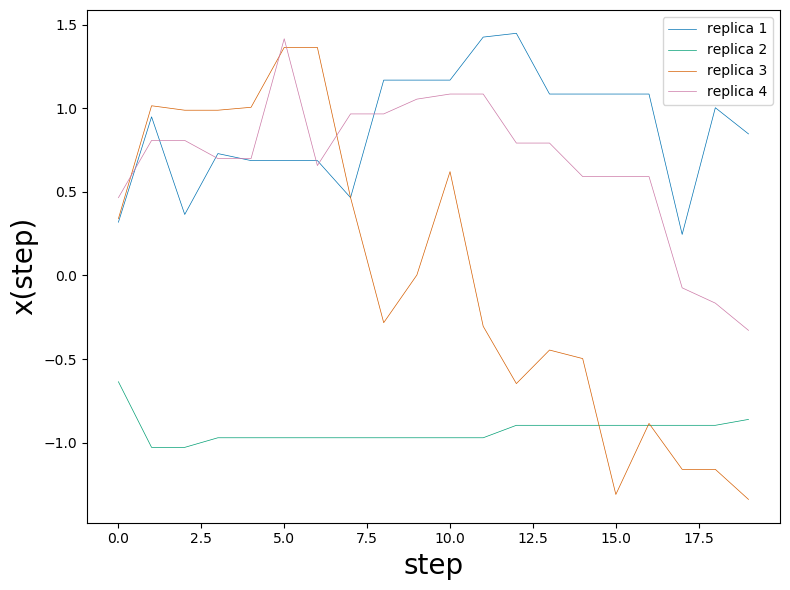

In [25]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [26]:

# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [27]:
#traj_sorted, temp_sorted = sort_traj(traj_replica, temp_replica)

In [28]:
#temp_sorted[1]

In [29]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_sorted[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1", "temperature 2", "temperature 3", "temperature 4"])
tight_layout()

UndefVarError: UndefVarError: traj_sorted not defined

In [30]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [31]:
pmf_observed, _ = getpmf(x_rou[1], grid_x = collect(x_grid), bandwidth=0.05);
#trag_sortの代わりに x_replica[1]*weight



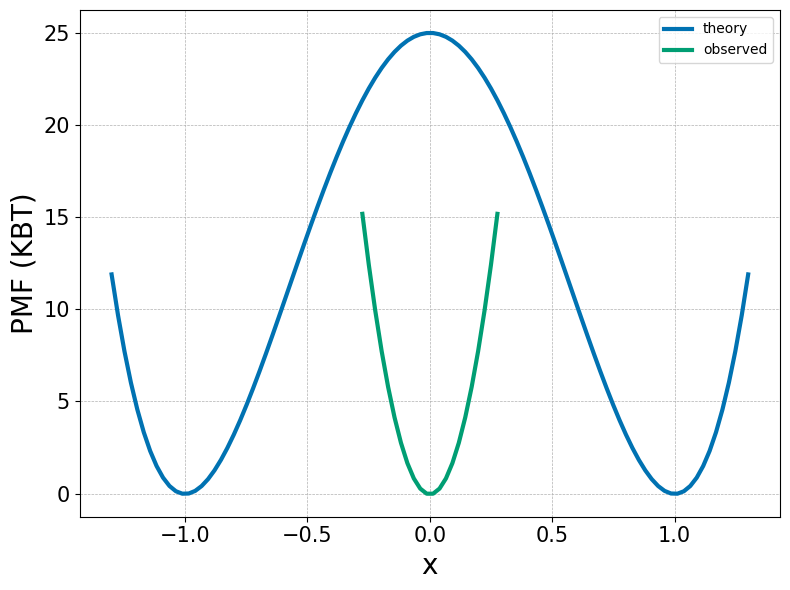

In [32]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_replica_exchange.png", dpi=350)